---
### Universidad de Costa Rica
#### IE0405 - Modelos Probabilísticos de Señales y Sistemas
---

- Estudiantes: **Daniel Alvarado Cordero, Miguel Roberto Jiménez Tung, Juan Ignacio Montealegre Salazar**
- Carné: **B90290, B94104, B95001**

# `P5` - *Procesos M/M/s*

> El caso especial de los procesos aleatorios donde existen "estados" y "transiciones" entre estos estados, las cadenas de Markov modelan las probabilidades de transición y el tiempo de permanencia entre cada estado. En particular, la teoría de colas describe la evolución del número de elementos en la fila, dado un flujo de entrada y un flujo de salida.

---

## 1. Sistemas M/M/1

Con una tasa de llegada $\lambda$ y un parámetro de tiempo de servicio $\nu$, un proceso de Markov con un solo servidor también recibe la notación de *sistema de colas* **M/M/1** (donde la M viene de Markov). Más en general, con $s$ servidores es un sistema **M/M/s**.

La simulación de un sistema del tipo **M/M/1** implica la generación de una llegada de "clientes" como una *corriente de Poisson*. Esto es equivalente a decir que tienen una distribución de probabilidad de *tiempo entre arribos* con distribución exponencial y parámetro $\lambda$.

Por su parte, el *tiempo de servicio* tiene también una distribución exponencial pero con parámetro $\nu$. A la relación $\lambda/\nu$ usualmente se le conoce como $\rho$.

**Nota**: El tiempo de servicio se asume independiente del tiempo de llegada.

#### Sobre la simulación

Es posible crear una simulación de $N$ clientes con sus respectivos tiempos de servicio, distribuidos en el tiempo.

Para medir el tiempo se puede utilizar una medida mínima arbitraria, pero que tenga sentido para el problema. Por ejemplo: si la tasa de llegada es de 1 persona/minuto, vale más tener una granularidad de segundos o decenas de segundos para capturar una precisión temporal adecuada.

**Nota**: De la selección de $N$ puede depender la precisión deseada para el resultado. Por ejemplo: con $N = 1000$ es posible obtener una precisión de hasta el 0,001 o 0,1% ($1/N$).

### 1.1. - Problema de ejemplo: un servidor web

> Un servidor web es modelado como un sistema M/M/1 con una tasa de arribo de dos solicitudes por minuto. Es deseado tener cuatro o menos solicitudes en fila el 99\% del tiempo. ¿Qué tan rápido debe ser el servicio? $\nu$ es el parámetro de solicitudes atendidas por minuto.

El estado $i$ es el número de clientes en el sistema. La longitud de la fila es $L_q = i - 1$ (*queue length*), en virtud de la solicitud que está siendo atendida en $s = 1$ servidores. Es posible encontrar que:

$$
P( \text{5 o más clientes en el sistema} ) = \sum_{i=5}^{\infty} (1 - \rho) \rho^i  = 1 - \sum_{i=0}^{4} (1 - \rho) \rho^i = \rho^5
$$

que depende de $\rho = \lambda/\nu$ y del parámetro de servicio $\nu$ buscado. 

De los datos del problema: $\lambda = 2$. Para tener una fila de 3 o menos clientes el 99\% del tiempo se necesita:

$$
\begin{aligned}
P( \text{5 o más clientes en el sistema} ) = \rho^5 & = \left( \frac{\lambda}{\nu} \right)^5 \leq 0.01 \\
\nu^5 & \geq \frac{\lambda^5}{0.01} = \frac{2^5}{0.01} = 3200 \quad \Rightarrow \quad \nu \geq 5.024
\end{aligned}
$$

es decir, el servidor debe atender más de 5,024 solicitudes por minuto en promedio para poder satisfacer el requisito.

En la siguiente simulación, con $N = 1000$, y $\nu = 3 < 5.024$ deberíamos obtener una probabilidad $P( \text{5 o más clientes en el sistema} ) > 0.01$ que **no** cumple con las especificaciones.

**Nota**: Observar el cambio de unidades de minutos a segundos, para lograr mayor "granularidad".

Parámetro lambda = 2.0
Parámetro nu = 3.0
Tiempo con más de 3 solicitudes en fila:
	 25.12%
	 No cumple con la especificación.
Simulación es equivalente a 7.90 horas.


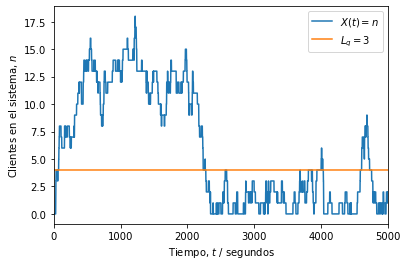

In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# Número de clientes
N = 1000

# Parámetro de llegada (clientes/segundos)
lam = 2/60

# Parámetro de servicio (servicios/segundos)
nu = 3/60

# Distribución de los tiempos de llegada entre cada cliente
X = stats.expon(scale = 1/lam)

# Distribución de los tiempos de servicio a cada cliente
Y = stats.expon(scale = 1/nu)

# Intervalos entre llegadas (segundos desde último cliente)
t_intervalos = np.ceil(X.rvs(N)).astype('int')

# Tiempos de las llegadas (segundos desde el inicio)
t_llegadas = [t_intervalos[0]]
for i in range(1, len(t_intervalos)):
    siguiente = t_llegadas[i-1] + t_intervalos[i]
    t_llegadas.append(siguiente)

# Tiempos de servicio (segundos desde inicio de servicio)
t_servicio = np.ceil(Y.rvs(N)).astype('int')

# Inicialización del tiempo de inicio y fin de atención
inicio = t_llegadas[0]          # primera llegada
fin = inicio + t_servicio[0]    # primera salida

# Tiempos en que recibe atención cada i-ésimo cliente (!= que llega)
t_atencion = [inicio]
for i in range(1, N):
    inicio = np.max((t_llegadas[i], fin))
    fin = inicio + t_servicio[i]
    t_atencion.append(inicio)

# Inicialización del vector temporal para registrar eventos
t = np.zeros(t_atencion[-1] + t_servicio[-1] + 1)

# Asignación de eventos de llegada (+1) y salida (-1) de clientes
for c in range(N):
    i = t_llegadas[c]
    t[i] += 1
    j = t_atencion[c] + t_servicio[c]
    t[j] -= 1

# Umbral de P o más personas en sistema (hay P - 1 en fila)
P = 5

# Instantes (segundos) de tiempo con P o más solicitudes en sistema
exceso = 0

# Proceso aleatorio (estados n = {0, 1, 2...})
Xt = np.zeros(t.shape)

# Inicialización de estado n
n = 0

# Recorrido del vector temporal y conteo de clientes (estado n)
for i, c in enumerate(t):
    n += c # sumar (+1) o restar (-1) al estado
    Xt[i] = n
    if Xt[i] >= P: 
        exceso += 1

# Fracción de tiempo con P o más solicitudes en sistema
fraccion = exceso / len(t)

# Resultados
print('Parámetro lambda =', str(lam*60))
print('Parámetro nu =', str(nu*60))
print('Tiempo con más de {} solicitudes en fila:'.format(P-2))
print('\t {:0.2f}%'.format(100*fraccion))
if fraccion <= 0.01:
    print('\t Sí cumple con la especificación.')
else:
    print('\t No cumple con la especificación.') 
print('Simulación es equivalente a {:0.2f} horas.'.format(len(t)/3600))

# Gráfica de X(t) (estados del sistema)
plt.figure()
plt.plot(Xt)
plt.plot(range(len(t)), (P-1)*np.ones(t.shape))
plt.legend(('$X(t) = n$', '$L_q = $' + str(P-2)))
plt.ylabel('Clientes en el sistema, $n$')
plt.xlabel('Tiempo, $t$ / segundos')
plt.xlim((0, 5000))
plt.show()

---
## 2. - Asignaciones

Es menester tomar una decisión con respecto al número de "servidores" necesarios para cierto proceso de vacunación, de forma tal que el sistema no exceda 50 personas en fila durante el 95% del tiempo de servicio. 

En un estudio de afluencia y del tiempo de servicio se asumen y determinan los siguientes parámetros:

- La tasa de llegada $\lambda$ es constante durante ocho horas de funcionamiento y tiene un valor de $\lambda = 4$ personas por minuto.

- La tasa de servicio $\nu$ de cada "servidor" (es decir, personal de salud tomando datos y vacunando) es constante durante ocho horas de funcionamiento y tiene un valor de $\nu = 0.25$ personas por minuto.

Entonces,

- (40%) Hacer la determinación teórica del número $s$ de servidores necesarios para cumplir el requisito.

Recordemos la probabilidad phi_0

$$
\phi_{0}=\left[\sum_{k=0}^{s-1} \frac{(s \rho)^{k}}{k !}+\frac{(s \rho)^{s}}{s !(1-\rho)}\right]^{-1}
$$

In [2]:
import math

#Función para calcular término phi_0
def phi_cero(s, p):
    suma = 0 
    # Se realiza primero una sumatoria
    for k in range(0, s):  # Rango de 0 a s-1
        suma+= ((s*p)**k)/(math.factorial(k))

    suma+= ((s*p)**s)/((math.factorial(s))*(1-p)) 
    suma = suma**-1
    return suma 



$$
\phi_{i}=\left\{\begin{array}{l}
\frac{(s \rho)^{i}}{i !} \phi_{0} \quad \text { para } i<s \\
\frac{s^{s} \rho^{i}}{s !} \phi_{0} \quad \text { para } i \geq s
\end{array}\right.
$$

In [3]:
#Funciones para calcular porbabilidad phi_i

def phi_i_menor(i, s, p, phi_0):  # phi_i para i < s
    formula = (((s*p)**i)/(math.factorial(i)))*phi_0
    return formula

def phi_i_mayor(i, s, p, phi_0):  # philetra _i para i > s
    formula = (((s**s)*(p**i))/(math.factorial(s)))*phi_0
    return formula


Se realiza la sumatoria 

In [4]:
# Cálculo de probabilidad

# Cantidad de servidores
s = 17
#Tasa de llegada lambda
lmbda = 4
#Tasa de salida v
v = 0.25
p = lmbda/(v*s)
prob_menos_50 = 0
n = 50+s
for i in range(n+1):
    # Calcular probabilidad de que hayan 50 personas en fila
    if (i < s):
        prob_menos_50+= phi_i_menor(i, s, p, phi_cero(s,p))
    if (i >= s):
        prob_menos_50+= phi_i_mayor(i, s, p, phi_cero(s,p))

# Probabilidad de que hayan 50 o más clientes en fila
prob_mas_50 = (1-prob_menos_50)*100
print("La probabilidad de tener más de 50 personas en fila con %.d servidores es de %.2f %%" %(s,prob_mas_50))


La probabilidad de tener más de 50 personas en fila con 17 servidores es de 3.35 %


A partir del resultado anterior obtenido con 17 servidores, podemos afirmar que esta cantidad de servidores cumple con lo requerido, ya que es menor al 5%. Por esta razón, la siguiente simulación se realizará con 17 servidores

- (60%) Modificar el código provisto para simular y corroborar el resultado anterior y crear al menos dos gráficas que muestren esta simulación.

In [5]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt


def Procesos(N, lam, nu, s):
    # Distribución de los tiempos de llegada entre cada cliente
    X = stats.expon(scale = 1/lam)

    # Distribución de los tiempos de servicio a cada cliente
    Y = stats.expon(scale = 1/(nu))

    # Intervalos entre llegadas (segundos desde último cliente)
    t_intervalos = np.ceil(X.rvs(N)).astype('int')

    # Tiempos de las llegadas (segundos desde el inicio)
    t_llegadas = [t_intervalos[0]]
    for i in range(1, len(t_intervalos)):
        siguiente = t_llegadas[i-1] + t_intervalos[i]
        t_llegadas.append(siguiente)

    # Tiempos de servicio (segundos desde inicio de servicio)
    t_servicio = np.ceil(Y.rvs(N)).astype('int')
    
    # Inicialización del tiempo de inicio y fin de atención
    inicio = t_llegadas[0]          # primera llegada
    fin = inicio + t_servicio[0]    # primera salida
    
    #Vector con los tiempos de fin de servicio de cada servidor
    servidores = np.zeros(s)
    
    #Asignacion de primer cliente
    servidores[0] = fin 

    # Tiempos en que recibe atención cada i-ésimo cliente (!= que llega)
    t_atencion = [inicio]
    
    for i in range(1, N):
        
        servidores_disponibles  = np.where(servidores <= t_llegadas[i])[0] # Servidores desocupados
        
        if servidores_disponibles.size == 0:
            inicio = np.min(servidores) + 1
            fin = inicio + t_servicio[i]  
            # Se fija el servidor
            k = servidores.tolist().index(np.min(servidores))
            
        else: 
            inicio = t_llegadas[i]
            fin = inicio + t_servicio[i]
            # Se fija el servidor
            k = servidores_disponibles[0]
        
        servidores[k] = fin
        t_atencion.append(inicio.astype(int))

    # Inicialización del vector temporal para registrar eventos
    t = np.zeros(t_atencion[-1] + max(t_servicio) + 1)

    # Asignación de eventos de llegada (+1) y salida (-1) de clientes
    for c in range(N):
        i = t_llegadas[c]
        t[i] += 1
        j = t_atencion[c] + t_servicio[c]
        t[j] -= 1

    # Umbral de P o más personas en sistema (hay P - 1 en fila)
    P = 52

    # Instantes (segundos) de tiempo con P o más solicitudes en sistema
    exceso = 0

    # Proceso aleatorio (estados n = {0, 1, 2...})
    Xt = np.zeros(t.shape)

    # Inicialización de estado n
    n = 0

    # Recorrido del vector temporal y conteo de clientes (estado n)
    for i, c in enumerate(t):
        n += c # sumar (+1) o restar (-1) al estado
        Xt[i] = n
        if Xt[i] >= P: 
            exceso += 1

    # Fracción de tiempo con P o más solicitudes en sistema
    fraccion = exceso / len(t)

    # Resultados
    print('Parámetro lambda =', str(lam*60))
    print('Parámetro nu =', str(nu*60))
    print('Cantidad de servidores =', str(s))
    print('Tiempo con más de {} solicitudes en fila:'.format(P-2))
    print('\t {:0.2f}%'.format(100*fraccion))
    
    if fraccion <= 0.05:
        print('\t Sí cumple con la especificación.')
    else:
        print('\t No cumple con la especificación.') 
    print('Simulación es equivalente a {:0.2f} horas.'.format(len(t)/3600))

    # Gráfica de X(t) (estados del sistema)
    plt.figure()
    plt.plot(Xt)
    plt.plot(range(len(t)), (P-1)*np.ones(t.shape))
    plt.legend(('$X(t) = n$', '$L_q = $' + str(P-2)))
    plt.ylabel('Clientes en el sistema, $n$')
    plt.xlabel('Tiempo, $t$ / segundos')
    plt.xlim((0, 15000))
    plt.show()
    

Parámetro lambda = 4.0
Parámetro nu = 0.25
Cantidad de servidores = 16
Tiempo con más de 50 solicitudes en fila:
	 12.81%
	 No cumple con la especificación.
Simulación es equivalente a 22.27 horas.


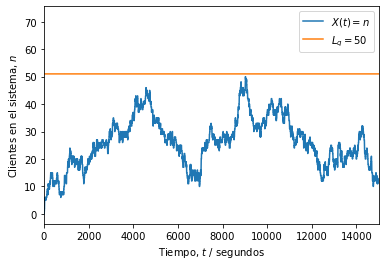

In [6]:
# Para s = 16
Procesos(5000, (4/60), (0.25/60), 16)

Parámetro lambda = 4.0
Parámetro nu = 0.25
Cantidad de servidores = 17
Tiempo con más de 50 solicitudes en fila:
	 0.00%
	 Sí cumple con la especificación.
Simulación es equivalente a 5.00 horas.


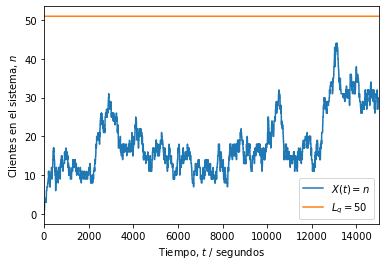

In [7]:
# Para s = 17
Procesos(1000, (4/60), (0.25/60), 17)

####  Analisis de Resultados
Como se puede apreciar en las gráficas anteriores, se demuestra que el mínimo de servidores nescesarios para que el sistema no exceda 50 personas en fila durante el 95% del tiempo de servicio es de 16.95 por lo que se toma el entero superior más próximo (17). En la primera gráfica, se puede ver que al usar 16 servidores, no se cumple la condición principal, obteniendo un número mayor de personas en fila por mas del 5% del tiempo total. Por otra parte, en la segunda gráfica, se puede ver como utilizando los servidores mínimos (17), se cumple la condición anterior. Además, es importante mencionar que la probabilidad de cambio de estado se trabaja a partir de 52 personas, ya que es la cantidad de personas con la que se sobrepasa la condicion de operación especificada (1 persona siendo antentidad y 50 personas en fila).


#### Sobre la presentación

El trabajo debe entregarse como un *notebook* de Jupyter nuevo (sin incluir información de este enunciado), en la forma de reporte. La primera parte de las asignaciones debe ser desarrollada por completo y en orden, editando las ecuaciones en $\LaTeX$. La segunda parte debe incluir el código desarrollado y sus resultados. Esto es enviado vía Mediación Virtual, uno por grupo.

---

**Universidad de Costa Rica**

Facultad de Ingeniería

Escuela de Ingeniería Eléctrica

---